In [ ]:
# Mount Google Drive (if your data is stored there; skip this if using local files)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Set the working directory (update the path based on your environment)
# If using Google Colab with Google Drive, specify the correct path; otherwise, use a local path.
os.chdir('/content/drive/MyDrive/Project_VTTI')  # Example for Google Colab
# os.chdir('/path/to/your/local/directory')  # Uncomment and replace for local usage

In [ ]:
# Importing the necessary libraries and functions!  XGBOOST handles Naan values.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
import os

# Function that aggregates all the csv files from both folders into two dataframes for identified and unknown
def aggregate_csvs(directory_path):
    # set up an Empty list
    dataframes = []

    # Going through directories to concatenate it all (all the CSV's)
    for subdir, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.csv'):
                filepath = os.path.join(subdir, file)
                df = pd.read_csv(filepath)
                dataframes.append(df)

    # Combine all DataFrames into one
    aggregated_df = pd.concat(dataframes, ignore_index=True)
    return aggregated_df

identified_data = aggregate_csvs('Identified_Classifier') # target folder, identified_classifier is a split datasets
unknown_data = aggregate_csvs('Unknown_Classifier')# unknown_classifier is a split dataset



# The actual important features we want to try out.
def important_features(sigF):

    window_size_milliseconds_steering = 10000  # 10 seconds window of time
    window_size_milliseconds_distance = 1000  # 1 second window of time


    # Wheel positions features
    sigF['steering_stability'] = sigF['vtti.steering_wheel_position'].rolling(window=window_size_milliseconds_steering).std()

    # Pedal features
    sigF['brake_duration'] = sigF.groupby((sigF['vtti.pedal_brake_state'] != sigF['vtti.pedal_brake_state'].shift()).cumsum()).cumcount() * sigF['vtti.pedal_brake_state']
    sigF['brake_event'] = sigF['vtti.pedal_brake_state'].diff().apply(lambda x: 1 if x == 1 else 0) #  Brake event important!
    sigF['brake_frequency'] = sigF['brake_event'].rolling(window=window_size_milliseconds_steering).sum()


    # Lateral Position
    sigF['avg_abs_distance_from_center'] = sigF['vtti.lane_distance_off_center'].abs().rolling(window=window_size_milliseconds_distance).mean()
    sigF['lateral_velocity'] = sigF['vtti.lane_distance_off_center'].diff()
    sigF['lateral_acceleration'] = sigF['lateral_velocity'].diff()




    return sigF

identified_data_RNN_Bi = important_features(identified_data) # New dataframe with only the significant features included!
unknown_data_RNN_Bi = important_features(unknown_data)       # Same thing was the line above!



# Our significant features (the ones we defined earlier)
#significant_columns = ['steering_stability','brake_duration','brake_frequency',
                      #'avg_abs_distance_from_center','lateral_velocity','lateral_acceleration']

# New sig features

significant_columns = ['lateral_velocity','brake_frequency',
                       'avg_abs_distance_from_center','lateral_acceleration']   # WORKs

identified_data_RNN_Bi = identified_data_RNN_Bi[significant_columns] # Code that makes the dataframe shorter based on the features we want to keep
unknown_data_RNN_Bi = unknown_data_RNN_Bi[significant_columns] # Does same thing as line above

In [ ]:
identified_data_RNN_Bi.dropna(inplace=True) #Drop Null values
unknown_data_RNN_Bi.dropna(inplace=True)

<ipython-input-5-a1e8f220b36e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_data_RNN_Bi.dropna(inplace=True) #Drop Null values
<ipython-input-5-a1e8f220b36e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data_RNN_Bi.dropna(inplace=True)


In [ ]:
print(identified_data_RNN_Bi.shape) # Make sure the shapes are healty (as we expect them to be)
print(unknown_data_RNN_Bi.shape)

(1022486, 4)
(1069361, 4)


In [ ]:
print(identified_data_RNN_Bi[['lateral_velocity','brake_frequency',
                       'avg_abs_distance_from_center','lateral_acceleration']].isna().sum()) # CHECK NULL VALUES FOR IDENTIFIED DATASET BEFORE PROCEEDING

lateral_velocity                0
brake_frequency                 0
avg_abs_distance_from_center    0
lateral_acceleration            0
dtype: int64


In [ ]:
print(unknown_data_RNN_Bi[['lateral_velocity','brake_frequency',
                       'avg_abs_distance_from_center','lateral_acceleration']].isna().sum()) # CHECK NULL VALUES FOR UNKNOWN DATASET BEFORE PROCEEDING

lateral_velocity                0
brake_frequency                 0
avg_abs_distance_from_center    0
lateral_acceleration            0
dtype: int64


In [ ]:
print(identified_data_RNN_Bi[0:100]) # Check healthy Shape for identified data

       lateral_velocity  brake_frequency  avg_abs_distance_from_center  \
15038          0.000000             58.0                    124.497663   
15039          0.000000             58.0                    124.490494   
15040          0.000000             58.0                    124.488096   
15041          0.000000             58.0                    124.485699   
15042          0.000000             58.0                    124.483301   
...                 ...              ...                           ...   
15133          0.000000             58.0                    118.997795   
15134          0.000000             58.0                    118.890905   
15135         73.443410             58.0                    118.917091   
15136         38.161072             58.0                    118.922848   
15137         -0.677319             58.0                    118.927674   

       lateral_acceleration  
15038              0.000000  
15039              0.000000  
15040              0.

In [ ]:
print(unknown_data_RNN_Bi[0:100000]) # Check healthy Shape for unknown data

        lateral_velocity  brake_frequency  avg_abs_distance_from_center  \
10433           0.000000              1.0                      8.499999   
10434           0.000000              1.0                      8.499999   
10435           0.000000              1.0                      8.499999   
10436           0.000000              1.0                      8.499999   
10437           0.000000              1.0                      8.499999   
...                  ...              ...                           ...   
294583          3.894670              0.0                     30.364727   
294584          4.233342              0.0                     30.392145   
294585         -1.550535              0.0                     30.418520   
294586          9.001236              0.0                     30.452966   
294587         11.937995              0.0                     30.500365   

        lateral_acceleration  
10433               0.000000  
10434               0.000000  
10435 

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Importing the necessary libraries: below is a basic version, you can make it as sophisitcated as you want

SEQUENCE_LENGTH = 12  # This means the RNN will consider 12 rows at a time. Adjust as needed.

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

identified_data_RNN_Bi['label'] = 1
unknown_data_RNN_Bi['label'] = 0

# Labels and features separation (important step! )
identified_labels = identified_data_RNN_Bi.pop('label').values
unknown_labels = unknown_data_RNN_Bi.pop('label').values

# aggregating the identified and unknown data for scaling in the next line of code!
all_data_RNN_Bi = pd.concat([identified_data_RNN_Bi, unknown_data_RNN_Bi])

#  Scaling the data (important step)
scaler = StandardScaler()
all_data_scaled_RNN_Bi = scaler.fit_transform(all_data_RNN_Bi)

# Separating the scaled data back into identified and unknown
identified_data_scaled_RNN_Bi = all_data_scaled_RNN_Bi[:len(identified_data_RNN_Bi)]
unknown_data_scaled_RNN_Bi = all_data_scaled_RNN_Bi[len(identified_data_RNN_Bi):]

# here, creating sequences for each class
identified_sequences_RNN_Bi = create_sequences(identified_data_scaled_RNN_Bi, SEQUENCE_LENGTH)
unknown_sequences_RNN_Bi = create_sequences(unknown_data_scaled_RNN_Bi, SEQUENCE_LENGTH)

identified_labels = identified_labels[-len(identified_sequences_RNN_Bi):]
unknown_labels = unknown_labels[-len(unknown_sequences_RNN_Bi):]

X = np.vstack((identified_sequences_RNN_Bi, unknown_sequences_RNN_Bi))
y = np.hstack((identified_labels, unknown_labels))

# Splitting (test, train etc)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5)


<ipython-input-11-4297a624b46e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_data_RNN_Bi['label'] = 1
<ipython-input-11-4297a624b46e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data_RNN_Bi['label'] = 0


In [ ]:
import tensorflow as tf
from tensorflow import keras # Importing the necessary libraries (especially Keras)
from sklearn.metrics import classification_report

# Define BiRNN model
model_birnn = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.SimpleRNN(50, return_sequences=True), input_shape=(SEQUENCE_LENGTH, len(significant_columns))),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(25, return_sequences=False)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

model_birnn.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Trainining the BI model with certain parameters, change those based on your needs and computational ability
history_birnn = model_birnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))# epochs and batch size etc are abitrary. Change as needed.
# Predicting the labels for the validation set
y_pred_birnn = model_birnn.predict(X_val)
y_pred_binary_birnn = [1 if y[0] > 0.5 else 0 for y in y_pred_birnn] # here probabilities are converted to the binary labels
# # defining the classification report (accuracy etc )
report_birnn = classification_report(y_val, y_pred_binary_birnn)
print(report_birnn)


Epoch 1/10
26148/26148 [==============================] - 481s 18ms/step - loss: 0.5730 - accuracy: 0.6977 - val_loss: 0.5412 - val_accuracy: 0.7277
Epoch 2/10
26148/26148 [==============================] - 486s 19ms/step - loss: 0.5342 - accuracy: 0.7240 - val_loss: 0.5386 - val_accuracy: 0.7221
Epoch 3/10
26148/26148 [==============================] - 491s 19ms/step - loss: 0.5339 - accuracy: 0.7246 - val_loss: 0.5292 - val_accuracy: 0.7231
Epoch 4/10
26148/26148 [==============================] - 500s 19ms/step - loss: 0.5260 - accuracy: 0.7257 - val_loss: 0.5521 - val_accuracy: 0.7214
Epoch 5/10
26148/26148 [==============================] - 506s 19ms/step - loss: 0.5391 - accuracy: 0.7189 - val_loss: 0.5257 - val_accuracy: 0.7282
Epoch 6/10
26148/26148 [==============================] - 504s 19ms/step - loss: 0.5299 - accuracy: 0.7231 - val_loss: 0.4945 - val_accuracy: 0.7445
Epoch 7/10
26148/26148 [==============================] - 491s 19ms/step - loss: 0.5355 - accuracy: 0.7189

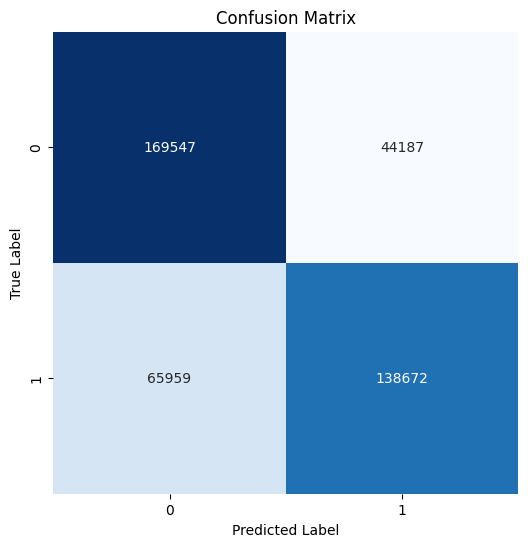

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix # Importing the libraries etc

cm = confusion_matrix(y_val, y_pred_binary_birnn) # defining the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show() # Displaying the matrix


13074/13074 [==============================] - 89s 7ms/step


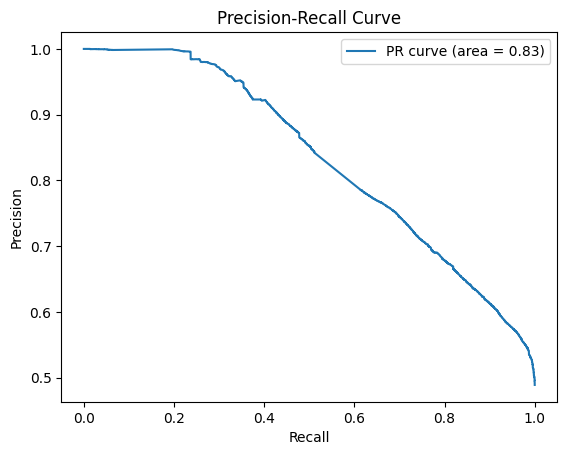

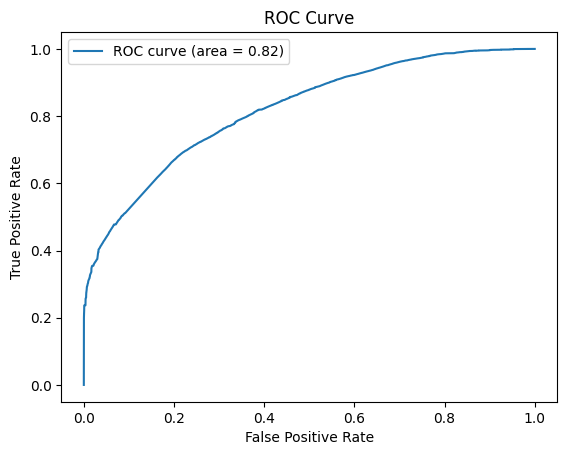

Log Loss: 0.5051666830007112
Cohen's Kappa is: 0.47199972491755704
Matthews Correlation Coefficient is: 0.47459154582317004
Confusion Matrix:
 [[169547  44187]
 [ 65959 138672]]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, average_precision_score, log_loss, cohen_kappa_score, matthews_corrcoef, confusion_matrix) # Importing the necessary metrics!

# Assuming X_val and y_val are already loaded! (if not, add code for that purpose or run it all together)
y_prob = model_birnn.predict(X_val).ravel()
y_pred = (y_prob > 0.5).astype(int)

# Plotting the Precision Curve (PRC)
precision, recall, _ = precision_recall_curve(y_val, y_prob)
average_precision = average_precision_score(y_val, y_prob)

plt.figure()
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plotting the ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Setting up the Log loss
print("Log Loss:", log_loss(y_val, y_prob))

# Displaying Cohen's Kappa metric (useful metric)
kappa = cohen_kappa_score(y_val, y_pred)
print("Cohen's Kappa is:", kappa)

# Displaying the Matthews Correlation Coefficient (useful metric)
mcc = matthews_corrcoef(y_val, y_pred)
print("Matthews Correlation Coefficient is:", mcc)

# Confusion Matrix, you can delete since we already have it!
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)


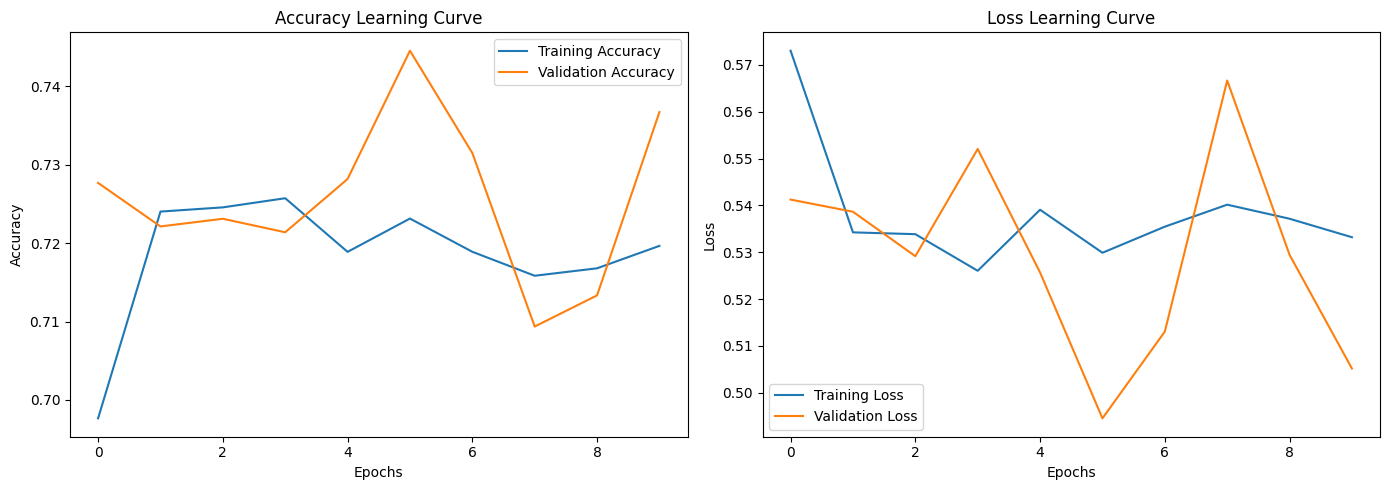

In [ ]:
plt.figure(figsize=(14, 5))

# Plotting the Accuracy Learning curve (standard stuff)
plt.subplot(1, 2, 1)
plt.plot(history_birnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_birnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the Loss learning curve (standard stuff)
plt.subplot(1, 2, 2)
plt.plot(history_birnn.history['loss'], label='Training Loss')
plt.plot(history_birnn.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
